# How to do Stereo Matching by SGM in OpenCV

> see code at: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py


In [18]:
'''
Simple example of stereo image matching and point cloud generation.
Resulting .ply file cam be easily viewed using MeshLab ( http://meshlab.sourceforge.net/ )
'''

import numpy as np
import cv2
import matplotlib.pyplot as plt

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')


def run_sgm(min_disp = 16, max_disp = 112):
    print('loading images...')
    imgL = cv2.pyrDown(cv2.imread('./files/aloeL.jpg'))  # downscale images for faster processing
    imgR = cv2.pyrDown(cv2.imread('./files/aloeR.jpg'))

    # disparity range is tuned for 'aloe' image pair
    window_size = 3
    #min_disp = 16
    stereo = cv2.StereoSGBM_create(
        minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = 16,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32
    )

    print('computing disparity...')
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

    print('generating 3d point cloud...',)
    h, w = imgL.shape[:2]
    f = 0.8*w                          # guess for focal length
    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disp, Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    mask = disp > disp.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = './results/aloe_out.ply'
    write_ply(out_fn, out_points, out_colors)
    print('%s saved' % out_fn)

    #cv2.imshow('left', imgL)
    #cv2.imshow('disparity', (disp-min_disp)/num_disp)
    #cv2.waitKey()
    return imgL, imgR, disp

Let us do the stereo matching and plot the disparity map.


Simple example of stereo image matching and point cloud generation.
Resulting .ply file cam be easily viewed using MeshLab ( http://meshlab.sourceforge.net/ )

loading images...
computing disparity...
generating 3d point cloud...
./results/aloe_out.ply saved


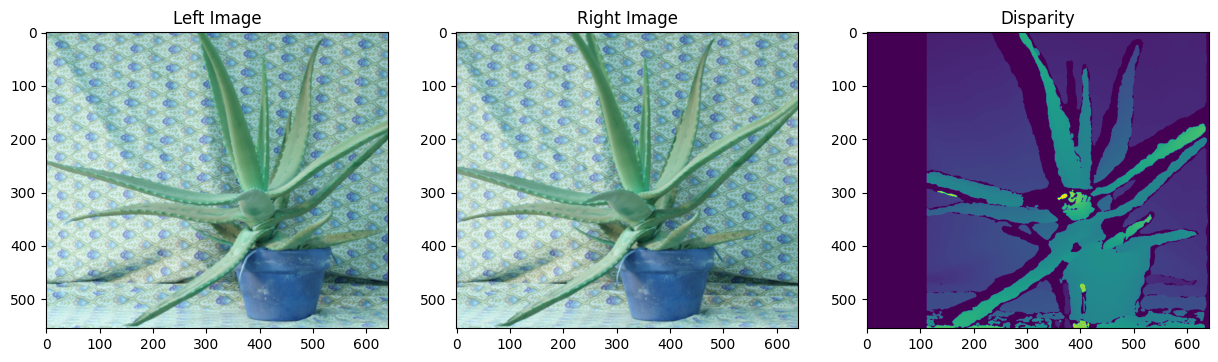

Done


In [22]:
print(__doc__)
min_disp = 16
max_disp = 112
num_disp = 112-min_disp
imgL, imgR, disp = run_sgm(min_disp, max_disp)
# Draw the rectified images
if 1:
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    axes[0].imshow(imgL)
    axes[0].title.set_text("Left Image")
    axes[1].imshow(imgR)
    axes[1].title.set_text("Right Image")
    axes[2].imshow((disp-min_disp)/num_disp)
    axes[2].title.set_text("Disparity")
    #plt.title("Left Image & RIght Image & Disparity", loc='center')
    #plt.savefig("./files/rectified_images.png")
    plt.show()
    print('Done')

Resulting .ply file cam be easily viewed using MeshLab ( http://meshlab.sourceforge.net/ ) as below:

<p align="center">
  <img src="results/aloe_out.png" alt="drawing" width="600"/>
</p>